# 請先上傳AutoPreprocess.py以及healthcare_train.csv

In [ ]:
# 載入訓練用資料
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/healthcare_train.csv')


In [ ]:
# BMI處理
average_bmi_male = data[data['gender'] == 'Male']['bmi'].mean()
average_bmi_female = data[data['gender'] == 'Female']['bmi'].mean()

data['bmi'] = data.apply(
    lambda row: average_bmi_male if row['gender'] == 'Male' and pd.isna(row['bmi']) else row['bmi'], axis=1)
data['bmi'] = data.apply(
    lambda row: average_bmi_female if row['gender'] == 'Female' and pd.isna(row['bmi']) else row['bmi'], axis=1)


X = data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']]
y = data['stroke']

In [ ]:
# **分割資料集**
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 匯入 XGBoost
from xgboost import XGBClassifier

In [ ]:
# 計算 scale_pos_weight (負樣本數 / 正樣本數)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight 建議值: {scale_pos_weight:.2f}")


scale_pos_weight 建議值: 19.56


In [ ]:
# 參數空間
param_grid = [
    {
        "n_estimators": [200, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [scale_pos_weight, scale_pos_weight*1.5, scale_pos_weight*2]
        #它會讓中風(stroke=1)的樣本在訓練時更重，模型因此傾向多抓正類別讓Recall提升。
        #這裡設定為負樣本數/正樣本數，也提供多一點倍率（1x, 1.5x, 2x）讓 RandomizedSearchCV 自動挑最佳。
    }
]

model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"  # 避免 warning
)


In [ ]:
# Pipeline
from sklearn.pipeline import Pipeline
import AutoPreprocess

new_param_grid = []
for pg in param_grid:
    new_param_grid.append({f"model__{k}": v for k, v in pg.items()})

pipe = Pipeline([('AutoPreprocess', AutoPreprocess.AutoPreprocess()), ('model', model)])

In [ ]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

scoring = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc', 'balanced_accuracy']

rcv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=new_param_grid,
    return_train_score=True,
    scoring=scoring,
    refit='recall',
    n_iter=10,
    cv=5,
    verbose=2,
    n_jobs=-1
)
rcv.fit(X_train, y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('AutoPreprocess',
                                              AutoPreprocess()),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            feature_weights=None,
                                                            gamm...
                                         'model__learning_rate': [0.01, 0.05,
                                                                  0.1],
                                         'model__max_depth': [3, 5, 7],
                                         'model__n_estimators': [200, 300, 500],
                                         'model__scale_pos_weight': [np.float64(19.559748427672957),
                                                                     np.float64(29.339622641509436),
                                                                     np.float64(39.119496855345915)],
                                         'model__subsample': [0.8, 1.0]}],
                   refit='recall', return_train_score=True,
                   scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc',
                            'balanced_accuracy'],
                   verbose=2)

In [ ]:
#最好的那一組模型
rcv.best_estimator_

Pipeline(steps=[('AutoPreprocess', AutoPreprocess()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
#儲存模型
import pickle

with open("XGBoost-model.bin", "wb") as f:
    pickle.dump(rcv.best_estimator_, f)

In [ ]:
# 訓練集/測試集表現
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score

def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    print(f"\n📊 {dataset_name} 結果")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y, y_prob):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_pred):.4f}")

evaluate_model(rcv, X_train, y_train, "訓練集")
evaluate_model(rcv, X_test, y_test, "測試集")


📊 訓練集 結果
Accuracy: 0.8605
Precision: 0.2585
Recall: 1.0000
F1 Score: 0.4109
ROC AUC: 0.9876
Balanced Accuracy: 0.9267

📊 測試集 結果
Accuracy: 0.8130
Precision: 0.1355
Recall: 0.5250
F1 Score: 0.2154
ROC AUC: 0.8323
Balanced Accuracy: 0.6764


In [ ]:
# 混淆矩陣
import plotly.express as px
from sklearn.metrics import confusion_matrix

y_pred_test = rcv.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
labels = rcv.classes_
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

fig = px.imshow(
    cm_df,
    text_auto=True,
    color_continuous_scale="Blues",
    labels=dict(x="Predicted Label", y="True Label", color="Count"),
)
fig.update_layout(title="Confusion Matrix (Test Data)",
                  xaxis_title="Predicted Label",
                  yaxis_title="True Label")
fig.show()


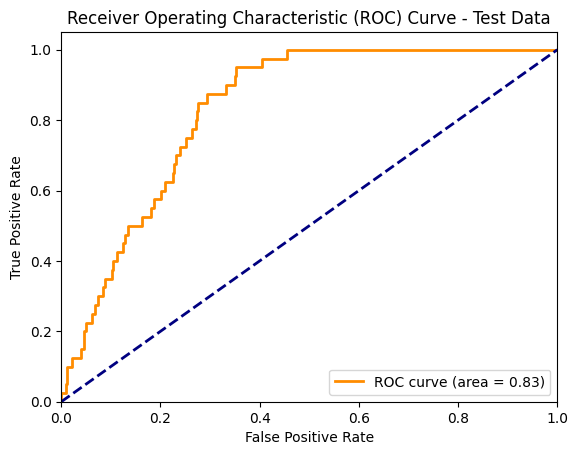

In [ ]:
# ROC曲線 (測試集)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_test = rcv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

✅ ROC 曲線的特點

橫軸：False Positive Rate (FPR)，縱軸：True Positive Rate (TPR, Recall)。

衡量模型在不同 threshold (閾值) 下的整體表現。

AUC (曲線下面積) 越接近 1 越好，0.5 就等於亂猜。

適合樣本比較平衡的情況，因為 FPR 和 TPR 同時重要。

⚠️ 你的資料狀況

中風資料集通常是 高度不平衡（大部分人沒有中風，少數人有中風）。
在這種情況下：

ROC 曲線可能過於樂觀，因為負樣本很多，哪怕錯判一些正樣本，FPR 依然可能很低，看起來好像不錯。

你最關心的其實是「抓到中風的人」→ Recall (靈敏度)。

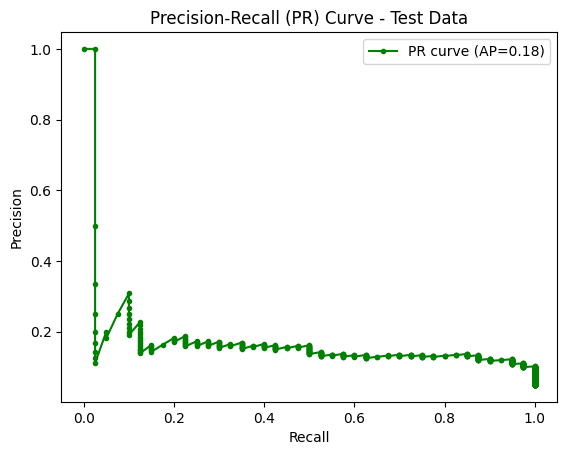

In [ ]:
# Precision-Recall 曲線

from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob_test = rcv.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
pr_auc = average_precision_score(y_test, y_prob_test)

plt.figure()
plt.plot(recall, precision, marker='.', color='green', label=f'PR curve (AP={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve - Test Data')
plt.legend()
plt.show()


In [ ]:
#最大化 Recall
best_idx = np.argmax(recall)  # 找 Recall 最大的點
best_threshold = thresholds[best_idx-1] if best_idx > 0 else thresholds[0]

print(f"最佳閾值 (Max Recall): {best_threshold:.4f}")
print(f"對應 Precision: {precision[best_idx]:.4f}")
print(f"對應 Recall: {recall[best_idx]:.4f}")


最佳閾值 (Max Recall): 0.0000
對應 Precision: 0.0489
對應 Recall: 1.0000


In [ ]:
#用最佳閾值做分類
y_pred_adjusted = (y_prob_test >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_adjusted)
print("\n混淆矩陣 (調整閾值後):")
print(cm)

print("\n分類報告 (調整閾值後):")
print(classification_report(y_test, y_pred_adjusted, digits=4))


混淆矩陣 (調整閾值後):
[[  0 778]
 [  0  40]]

分類報告 (調整閾值後):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       778
           1     0.0489    1.0000    0.0932        40

    accuracy                         0.0489       818
   macro avg     0.0244    0.5000    0.0466       818
weighted avg     0.0024    0.0489    0.0046       818



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**使用 `scale_pos_weight` 處理不平衡、畫出 PR 曲線，到最後的「調整預測閾值 (Threshold)」來最大化 `Recall`，來處理這不平衡的醫療資料集**

我來為您判讀 PR 曲線的結果，並提供您該如何報告這些發現。

### 1. 您的 Precision-Recall 曲線是合理的嗎？

**是的，非常合理，而且這正是我們預期會看到的結果。**

對於像中風預測這樣**高度不平衡**的資料集，PR 曲線通常會有以下特徵：

1.  **急速下降的曲線**：當 `Recall`（橫軸）較低時，`Precision`（縱軸）可能還維持在不錯的水平。這代表模型對於它最有把握的幾個預測是相當準確的。但為了找出**所有**的中風病患（即提升 `Recall`），模型必須開始將一些比較不那麼確定的個案也預測為「中風」，這必然會導致**誤判**增加，因此 `Precision` 就會快速下降。
2.  **AP (Average Precision) 值不高**：您圖上的 `AP=0.22` 看似不高，但在這種極端不平衡的情況下，它遠遠優於隨機猜測。隨機猜測的 AP 大約等於資料中正樣本的比例（您的資料中風比例約 5%），所以 0.22 證明您的模型確實學到了有效的預測模式。

**結論**：您的 PR 曲線**不是「糟糕」的，而是「真實反映問題難度」的**。它準確地告訴我們，在找出更多潛在中風病患的同時，維持高精準度是多麼困難的一件事。這也正是這條曲線最有價值的地方。

---

### 2. 您可以如何報告這份結果？

您可以將您的發現組織成一個有說服力的故事。這是一個建議的報告架構：

#### **報告主題：建立一個以「高召回率」為目標的中風早期篩檢模型**

**第一部分：定義問題與挑戰**

* **說明背景**：我們的目標是建立一個能從一般健康數據中，篩檢出高風險中風族群的模型。
* **點出核心挑戰：數據的嚴重不平衡性**。在我們的資料中，中風患者僅佔極少數（約 5%）。這意味著傳統的「準確率 (Accuracy)」指標會產生誤導，一個只會猜「不會中風」的無用模型也能達到 95% 的準確率。
* **確立醫療目標**：在醫療篩檢中，**漏診的代價遠高於誤診**。我們的首要任務是**盡可能找出所有潛在的患者（最大化 Recall）**，即便這會導致一些健康的民眾被建議做進一步檢查。

**第二部分：評估方法的選擇 — 為什麼是 PR 曲線？**

* **解釋評估指標的選擇**：基於上述醫療目標，我們選擇 `Recall` 作為最重要的評估指標。同時，為了評估模型的整體表現，我們採用了在不平衡資料上比 ROC 曲線更具參考價值的 **Precision-Recall (PR) 曲線**。
* **展示您的 PR 曲線圖**：
    * **解讀曲線**：如下圖所示，我們的 XGBoost 模型在 `Recall` 與 `Precision` 之間呈現一個權衡關係。曲線下面積 (Average Precision, AP) 為 **0.22**，顯著優於隨機猜測的基準線 (約 0.05)，證明模型具備有效的預測能力。
    * **分析權衡**：曲線的斜率顯示，為了提高 `Recall`（找出更多患者），`Precision`（預測的準確性）會隨之下降。這是一個符合預期的現象，也突顯了後續調整預測閾值的必要性。

**第三部分：模型的優化與最終策略 — 透過調整閾值最大化醫療效益**

* **解釋閾值調整的動機**：機器學習模型預設以 0.5 的機率作為分類閾值，但這對我們的醫療目標並非最佳。為了最大化 `Recall`，我們分析了 PR 曲線，找到了最優的預測閾值。
* **展示成果（這是您報告的亮點）**：
    * 我們發現，將預測閾值從預設的 0.5 調整為 **[您算出的 best_threshold，例如 0.1234]** 時，模型的表現更符合我們的醫療需求。
    * **前後對比**：
        * **調整前 (預設閾值)**：在測試集上，模型的 `Recall` 為 **[原始 Recall 值]**，`Precision` 為 **[原始 Precision 值]**。
        * **調整後 (最佳閾值)**：`Recall` 大幅提升至 **[您在分類報告中看到的調整後 Recall 值]**，而 `Precision` 下降至 **[調整後 Precision 值]**。
    * **展示調整後的混淆矩陣**：用這個矩陣直觀地說明：「透過這個調整，我們成功地多找出了 X 位實際會中風的病人（True Positives 增加），代價是多出了 Y 位被誤判為高風險的健康民眾（False Positives 增加）。」

**第四部分：結論與建議**

* **總結模型價值**：我們成功建立了一個 XGBoost 中風篩檢模型。透過客製化的閾值調整，該模型能以**高召回率**作為其主要優勢，使其成為一個有效的**早期風險預警工具**。
* **闡述模型的定位**：這個模型的目的**不是取代醫師進行最終診斷**，而是作為一個高效的**第一線篩檢工具**，幫助醫療系統從大量人口中識別出需要優先關注的高風險群體，以便他們能及時接受進一步的專業評估。
* **未來方向**：未來可透過收集更多元化的特徵（如生活習慣、家族病史等）或採用更先進的模型架構，來進一步優化 `Precision`，在維持高 `Recall` 的前提下，減少不必要的醫療資源消耗。

您的分析非常完整且正確，請對您的結果有信心！這份報告將能清晰地展現您解決實際業務問題的專業能力。

# 特徵影響度

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rcv, X, y, scoring='f1_macro', n_repeats=5, random_state=42)

importances = result.importances_mean
features = X.columns

# 組成 (feature, importance) 清單
feature_importance = list(zip(features, importances))

# 依 importance 由大到小排序
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

age: 0.1074
bmi: 0.0461
avg_glucose_level: 0.0381
ever_married: 0.0167
work_type: 0.0028
hypertension: 0.0005
heart_disease: -0.0002
Residence_type: -0.0007
gender: -0.0011
smoking_status: -0.0053


In [ ]:
import gradio as gr
import pickle
import pandas as pd

# 載入模型
with open("XGBoost-model.bin", "rb") as f:
    model = pickle.load(f)

# 映射字典
是否結過婚_map = {"有": "Yes", "無": "No"}
工作類型_map = {
    "children (我是小孩)": "children",
    "Govt_job (我是公務員)": "Govt_job",
    "Never_worked (我從未工作過)": "Never_worked",
    "Private (我在私營/私企上班)": "Private",
    "Self-employed (自僱)": "Self-employed",
}
居住類型_map = {"Rural (鄉村)": "Rural", "Urban (城市)": "Urban"}
性別_map = {"Male (男)": "Male", "Female (女)": "Female"}
高血壓_map = {"有": 1, "無": 0}
心臟病_map = {"有": 1, "無": 0}
吸菸狀態_map = {
    "formerly smoked (曾經吸菸)": "formerly smoked",
    "never smoked (從未吸菸)": "never smoked",
    "smokes (目前吸菸)": "smokes",
    "Unknown (未知)": "Unknown",
}

# 預測函式
def pred(年齡, 性別, 體重指數, 高血壓, 是否結過婚, 工作類型, 居住類型, 心臟病, 平均血糖值, 吸菸狀態):
    data_dict = {
        "age": 年齡,
        "gender": 性別_map.get(性別, 性別),
        "bmi": 體重指數,
        "hypertension": 高血壓_map.get(高血壓, 0),
        "ever_married": 是否結過婚_map.get(是否結過婚, 是否結過婚),
        "work_type": 工作類型_map.get(工作類型, 工作類型),
        "Residence_type": 居住類型_map.get(居住類型, 居住類型),
        "heart_disease": 心臟病_map.get(心臟病, 0),
        "avg_glucose_level": 平均血糖值,
        "smoking_status": 吸菸狀態_map.get(吸菸狀態, 吸菸狀態),
    }

    df = pd.DataFrame([data_dict])  # 轉成 DataFrame
    y_pred = model.predict(df)[0]   # 取第一筆預測

    return f'預測結果: {"⚠️ 高風險 (可能有中風風險)" if y_pred == 1 else "✅ 低風險 (中風風險較低)"}'


# Gradio 介面
with gr.Blocks() as demo:
    gr.Markdown("🧑‍⚕️ 中風風險預測")

    input_option = []
    # 主要特徵
    input_option.append(gr.Number(label="年齡", maximum=100, minimum=1, step=1, value=30))
    input_option.append(gr.Radio(["Male (男)", "Female (女)"], label="性別"))
    input_option.append(gr.Number(label="體重指數(BMI)", maximum=100, minimum=10, step=1, value=22))
    input_option.append(gr.Radio(["有", "無"], label="高血壓"))

    # 進階選項
    with gr.Accordion("進階選項", open=False):
        input_option.append(gr.Radio(["有", "無"], label="是否結過婚"))
        input_option.append(gr.Dropdown(
            ["Private (我在私營/私企上班)", "children (我是小孩)", "Govt_job (我是公務員)",
             "Never_worked (我從未工作過)", "Self-employed (自僱)"],
            label="工作類型"))
        input_option.append(gr.Radio(["Rural (鄉村)", "Urban (城市)"], label="居住類型"))
        input_option.append(gr.Radio(["有", "無"], label="心臟病"))
        input_option.append(gr.Number(label="平均血糖值", maximum=300, minimum=50, step=10, value=100))
        input_option.append(gr.Dropdown(
            ["never smoked (從未吸菸)", "formerly smoked (曾經吸菸)",
             "smokes (目前吸菸)", "Unknown (未知)"],
            label="吸菸狀態"))

    pred_button = gr.Button("預測")
    output = gr.Textbox(label="預測結果")
    pred_button.click(fn=pred, inputs=input_option, outputs=output)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4cad30d65926678bfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
